In [1]:
!nvidia-smi

Wed Mar 24 18:29:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = pd.get_dummies(y_train.flatten()).values.astype(np.float32)
y_test = pd.get_dummies(y_test.flatten()).values.astype(np.float32)

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [6]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [7]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[np.argmax(label_batch[n])])
      plt.axis('off')

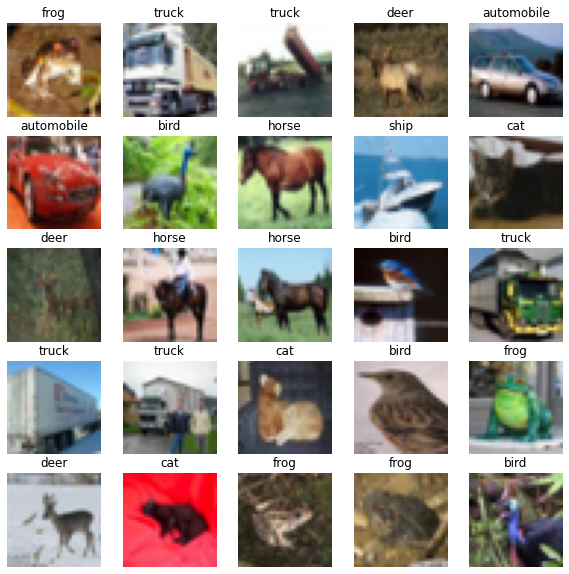

In [8]:
image_batch, label_batch = x_train[:32], y_train[:32]
show_batch(image_batch, label_batch)

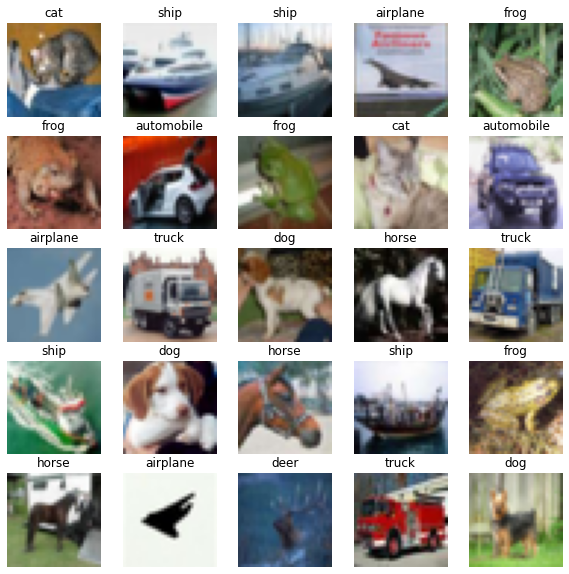

In [9]:
image_batch, label_batch = x_test[:32], y_test[:32]
show_batch(image_batch, label_batch)

In [10]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = keras.layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = keras.layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
def Model():
  return resnet_v1((32,32,3), 20) ## Returns a ResNet20 model.

In [12]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32

In [13]:
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = image/255.
  return image, label

In [14]:
@tf.function
def get_bbox(l):
  cut_rat = tf.math.sqrt(1.-l)

  cut_w = IMG_SHAPE*cut_rat #rw
  cut_w = tf.cast(cut_w, tf.int32)
  
  cut_h = IMG_SHAPE*cut_rat #rh
  cut_h = tf.cast(cut_h, tf.int32)
  
  cx = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #rx
  cy = tf.random.uniform((1,), minval=0, maxval=IMG_SHAPE, dtype=tf.int32) #ry
  
  bbx1 = tf.clip_by_value(cx[0] - cut_w // 2, 0, IMG_SHAPE)
  bby1 = tf.clip_by_value(cy[0] - cut_h // 2, 0, IMG_SHAPE)
  bbx2 = tf.clip_by_value(cx[0] + cut_w // 2, 0, IMG_SHAPE)
  bby2 = tf.clip_by_value(cy[0] + cut_h // 2, 0, IMG_SHAPE)
  
  target_h = bby2-bby1
  if target_h ==0:
    target_h+=1

  target_w = bbx2-bbx1
  if target_w ==0:
    target_w+=1

  return bbx1, bby1, target_h, target_w

@tf.function
def cutmix(a, b):
  
  (image1, label1), (image2, label2) = a, b

  alpha = [1.]
  beta = [1.]
  
  ## Get sample from beta distribution
  dist = tfd.Beta(alpha, beta)
  ## Lambda
  l = dist.sample(1)[0][0]

  ## Get bbox ofsets and heights and widths
  bbx1, bby1, target_h, target_w = get_bbox(l)

  ## Get patch from image2
  crop2 = tf.image.crop_to_bounding_box(image2, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  image2 = tf.image.pad_to_bounding_box(crop2, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)
  ## Get patch from image1
  crop1 = tf.image.crop_to_bounding_box(image1, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  img1 = tf.image.pad_to_bounding_box(crop1, bby1, bbx1, IMG_SHAPE, IMG_SHAPE)

  ## Subtract the patch from image1 so that patch from image2 can be put on instead
  image1 = image1-img1
  ## Add modified image1 and image2 to get cutmix image
  image = image1+image2

  ## Adjust lambda according to pixel ration
  l = 1 - (target_w * target_h) / (IMG_SHAPE * IMG_SHAPE)
  l = tf.cast(l, tf.float32)

  ## Combine labels
  label = l*label1+(1-l)*label2

  return image, label

In [15]:
trainloader1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
trainloader2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)

trainloader = tf.data.Dataset.zip((trainloader1, trainloader2))
trainloader = (
    trainloader
    .shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

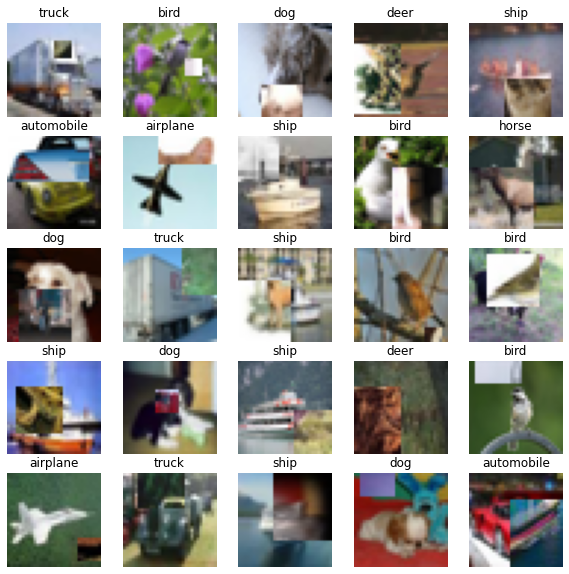

In [16]:
image_batch, label_batch = next(iter(trainloader))
image_batch.shape, label_batch.shape

show_batch(image_batch, label_batch)

In [17]:
initial_model = Model()
initial_model.save_weights("initial_weights.h5")

In [18]:
model = Model()
model.load_weights("initial_weights.h5")

In [19]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(trainloader,validation_data=testloader, epochs=15)

test_loss, test_accuracy = model.evaluate(testloader)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 68s 23ms/step - loss: 2.1208 - accuracy: 0.3285 - val_loss: 1.7153 - val_accuracy: 0.4668
Epoch 2/15
1563/1563 [==============================] - 36s 23ms/step - loss: 1.8028 - accuracy: 0.4899 - val_loss: 1.4376 - val_accuracy: 0.5307
Epoch 3/15
1563/1563 [==============================] - 36s 23ms/step - loss: 1.6897 - accuracy: 0.5453 - val_loss: 1.3192 - val_accuracy: 0.5888
Epoch 4/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.6283 - accuracy: 0.5748 - val_loss: 1.2645 - val_accuracy: 0.6044
Epoch 5/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.5870 - accuracy: 0.5967 - val_loss: 1.0001 - val_accuracy: 0.7049
Epoch 6/15
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5491 - accuracy: 0.6119 - val_loss: 0.9223 - val_accuracy: 0.7412
Epoch 7/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.5315 - accuracy: 0.6221 - val_loss: 0.9925 -

In [20]:
model = Model()
model.load_weights("initial_weights.h5")

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [22]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_ds,validation_data=testloader, epochs=15)

test_loss, test_accuracy = model.evaluate(testloader)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 23s 13ms/step - loss: 1.7236 - accuracy: 0.4304 - val_loss: 1.4416 - val_accuracy: 0.5334
Epoch 2/15
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1179 - accuracy: 0.6580 - val_loss: 1.0732 - val_accuracy: 0.6734
Epoch 3/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9252 - accuracy: 0.7326 - val_loss: 1.1228 - val_accuracy: 0.6711
Epoch 4/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8101 - accuracy: 0.7757 - val_loss: 1.0569 - val_accuracy: 0.7009
Epoch 5/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.7242 - accuracy: 0.8127 - val_loss: 1.1543 - val_accuracy: 0.6848
Epoch 6/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6599 - accuracy: 0.8413 - val_loss: 1.1063 - val_accuracy: 0.7121
Epoch 7/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6056 - accuracy: 0.8631 - val_loss: 1.1366 -